### Data Augmentation Tutorial
 



In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Load the cats_vs_dogs dataset

In [2]:
(train_ds, test_ds), info = tfds.load('cats_vs_dogs',split=['train[:1000]', 'train[1000:1500]'], with_info=True, as_supervised=True)

In [103]:
print(info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

#### Have a look at some images from the dataset.

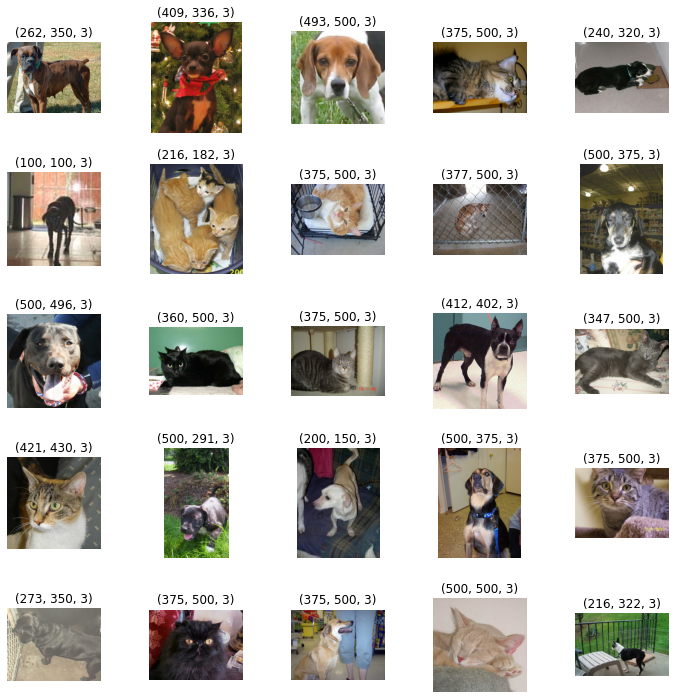

In [4]:
train_ds.prefetch(100)
fig, ax = plt.subplots(5,5,figsize=(10,10))
fig.tight_layout()
ax = ax.flatten()
for i,(img, label) in enumerate(train_ds):
     
    
    
    ax[i].imshow((img))
    ax[i].set_title((img.numpy().shape))
    ax[i].axis("off")
    if i == 24:
        break




### Data Augmentation
We will use the [tf/keras/preprocessing/image/ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for live data augmentation.
Sadly we can't use a tf.dataset to create the generator. We need an np.array, images in a directory or a dataframe.
Lets make the dataset into an array.



In [104]:
# sadly needs np.array, images in directory or dataframe
# lets make the dataset an array

def dataset_to_array(dataset):
    x = []
    y = []
    for img, label in dataset:
        # reshape because arrays needs consistent shape
        x.append(np.asarray(tf.image.resize((img), (200, 200))))
        y.append(label)
    return np.asarray(x), np.asarray(y)


train_images, train_labels = dataset_to_array(train_ds)
 

Initialize the generator and create an iterator.
The rescale transformation is applied last. Use this to make sure that pixels are in a valid range after other transformations.

In [105]:
# create the generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, # do this to avoid problems wiht clipping
    rotation_range=40,
    brightness_range=(0.3,0.7),
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# create an iterator using datagen.flow
train_generator = datagen.flow(train_images, train_labels, batch_size=32)

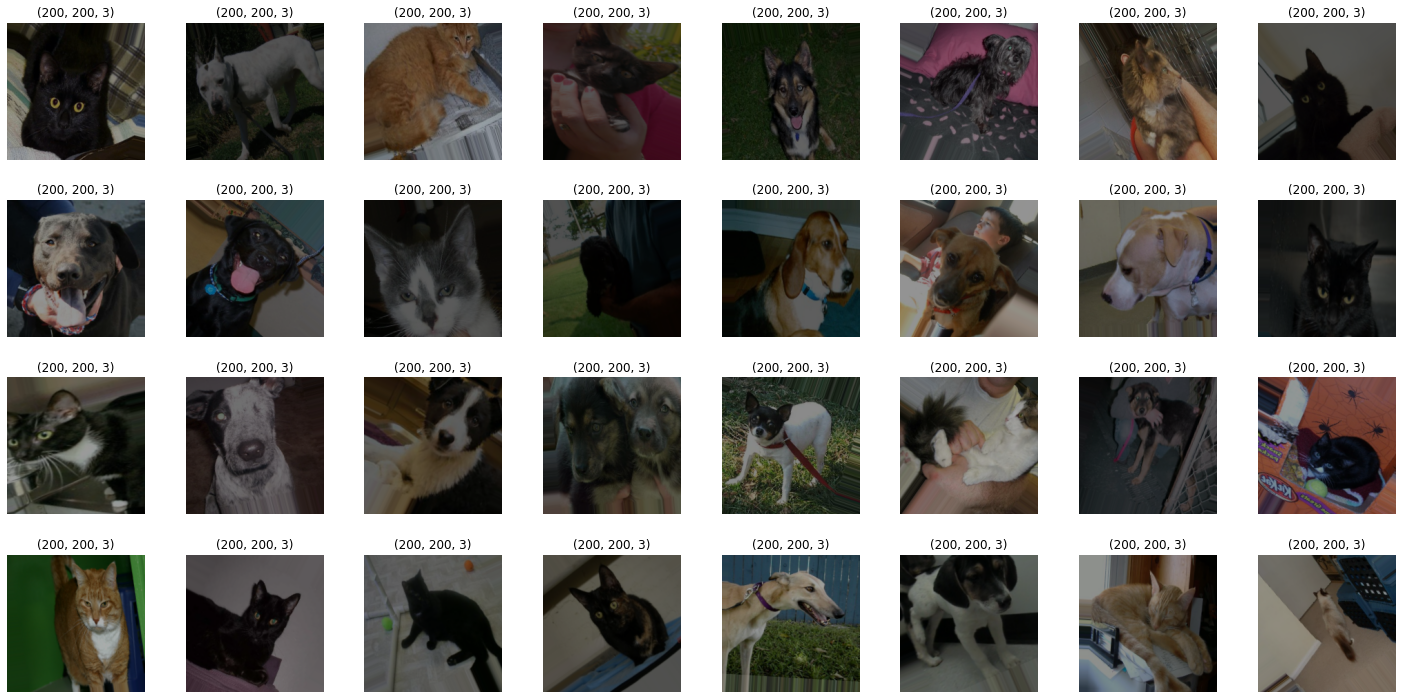

In [106]:
# plot images of first batch
fig, ax = plt.subplots(4,8,figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for img_b, label_b in train_generator:
    for i in range(32):   
        img = img_b[i]
        l = label_b[i]
        
        ax[i].imshow(img)  
        ax[i].set_title((img.shape))
        ax[i].axis("off")

    break   

We have batches of images, ready to train our network.
The Iterator loops indefinetly. Make sure to include a break

In [110]:
for i, (img_b, label_b) in enumerate(train_generator):
    if i >= 100:
        break


### Prepare the TensorFlow dataset.
In the case that you still want to use the tf.Dataset input pipeline, lets create a tf.Dataset from our generator.
We will use *tf.data.Dataset.from_generator*. Even though our generator is called a generator we cant just use it as an argument.
But we can define our own generator which returns a number of batches using the train_generator like below.





*Note: It might be possible to pass the tf.data.Dataset.from_generator function as generator and all the arguments over the args argument. I did not try yet because this way looked less tedious. If you make it work let me know*

In [78]:
def generator(num_batches):
    for i, train_tuple in enumerate(train_generator):
        yield train_tuple
        if i >= num_batches:
            return


In [107]:
num_batches = 50
# pass generator, outputtypes and num_batches
# args needs to be tuple of tensors
train_dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32), args=(tf.constant(num_batches),))

# Now do the remaining tensorflow pipeline like you are used to
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.uint8), 2)))
test_dataset = test_ds.map(lambda x, y: (x, tf.one_hot(y, 2)))

# train dataset already scaled to (0,1), resized and batched
train_dataset = train_dataset.map(lambda x,y: ((2*x-1), y)).prefetch(128)
test_dataset = test_dataset.map(lambda x,y: (tf.image.resize((2*(x/255)-1),(200, 200)), y)).batch(32).prefetch(128)

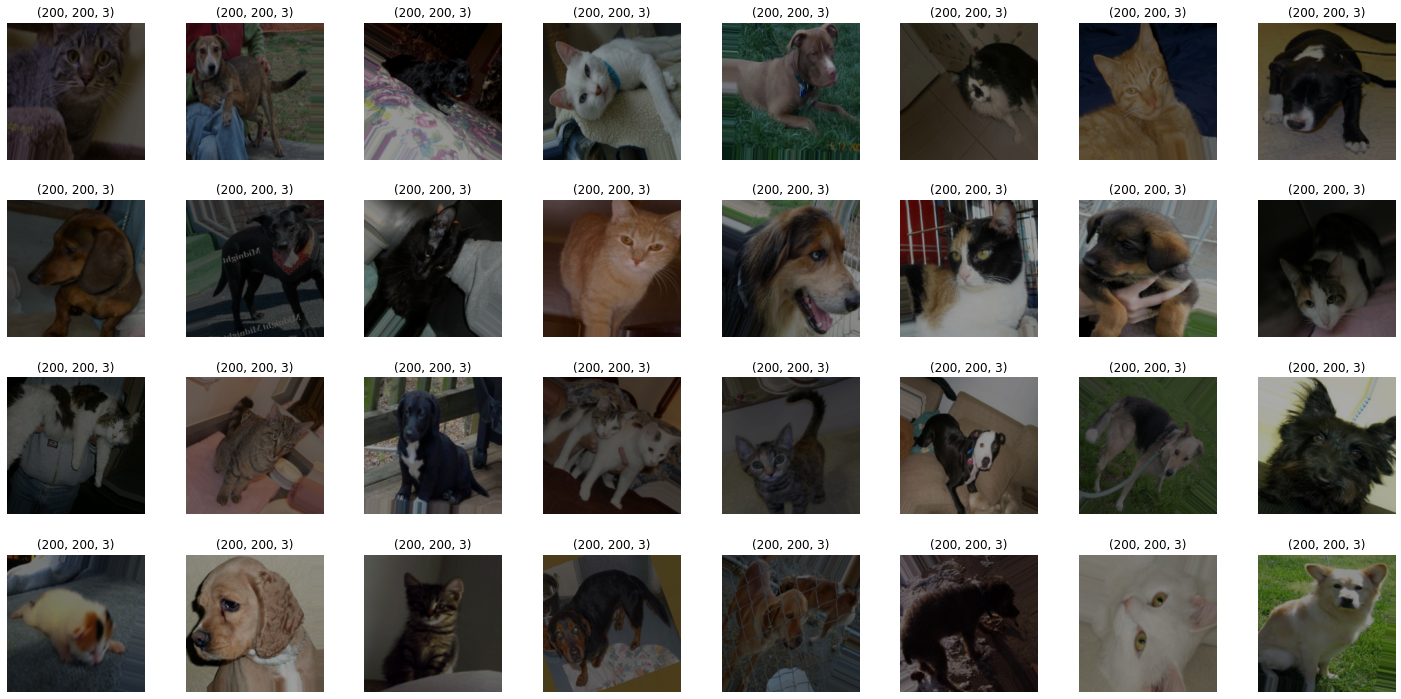

In [109]:
fig, ax = plt.subplots(4,8,figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for img_b, label in train_dataset:
    for i in range(32):   
        img = img_b[i]
        ax[i].imshow((img+1)/2)  
        ax[i].set_title((img.shape))
        ax[i].axis("off")

    break   
 

### Additional Notes
- Have a look at the docs [tf/keras/preprocessing/image/ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- As the image generation is live it will slow down training significantly
    - It is also possible to save the generated images and reuse for multiple training sessions
    - check out the save_to_dir parameter of the flow function for that




### Build the model.
 

In [88]:
from tensorflow.keras.layers import Layer

# You will implement a CNN. The layers you need are: tf.keras.layers.Conv2D, tf.keras.layers.MaxPool2D, 
# tf.keras.layers.Flatten, tf.keras.layers.Dense

# Input
# Convolutional layer: 32 kernels of size (3,3) with ReLU activation function (tf.keras.activations.relu)
# Note: In the first layer you have to provide the input shape to the function (argument: input_shape).
# Maxpooling layer: pooling size (2,2) and strides (2,2).
# Convolutional layer: 64 kernels of size (3,3) with ReLU activation function 
# Maxpooling layer: pooling size (2,2) and strides (2,2).
# Convolutional layer: 64 kernels of size (3,3) with ReLU activation function
# Flatten the resulting ferature maps.
# Fully connected layer with 64 hidden neurons and ReLU activation function.
# Fully connected layer with 10 output neurons and softmax activation function (tf.keras.activations.softmax).

class Model(Layer):
    
    def __init__(self):
        super(Model, self).__init__()
        ### YOUR CODE HERE ###
        # Initialize all layers.
        activation = tf.nn.leaky_relu
        self.conv_layer_1 = tf.keras.layers.Conv2D(
                                filters=32,
                                kernel_size=3,
                                activation=activation,
                                padding='valid',
                                input_shape=(200,200,3)
                            )
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_layer_2 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='same',
                                activation=activation
                            )
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_layer_3 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='same',
                                activation=activation
                            )
        self.conv_layer_4 = tf.keras.layers.Conv2D(
                                filters=64,
                                kernel_size=3,
                                padding='same',
                                activation=activation
                            )
        self.max_pool_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2))

        self.conv_layer_5 = tf.keras.layers.Conv2D(
                                filters=128,
                                kernel_size=3,
                                padding='same',
                                activation=activation
                            )
        self.conv_layer_6 = tf.keras.layers.Conv2D(filters=10,
                                kernel_size=3,
                                strides=3,
                                padding='same',
                                activation=activation
                            )
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        
        
         
        self.output_layer = tf.keras.layers.Dense(
                                units=2           
                            )
        ########################
        
    def call(self, x):
        ### YOUR CODE HERE ###
        # Define the model.
        x = self.conv_layer_1(x)
        x = self.max_pool_1(x)
        x = self.conv_layer_2(x)
        x = self.max_pool_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.max_pool_4(x)
        x = self.conv_layer_5(x)
        x = self.conv_layer_6(x)

        x = self.global_pool(x)
         
        x = self.output_layer(x)
 
        x = tf.nn.softmax(x)
 

        return x
        ######################

### Train the model.

In [89]:
def acc_metric(target,output):
    #print(tf.shape(target), tf.shape(output))
    acc = np.argmax(target, axis=1) == np.argmax(output, axis=1) ## how many items in pred and target are same (first cast output from float tensor to int --> rounding)
    acc = np.mean(acc)
    #acc = tf.reduce_sum(tf.cast(acc, tf.float32)) ## sum up all true predictions
    
    #acc = acc.numpy()/target.shape[0] ## divide by 32
    
    return acc

In [100]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    #print('pred' , prediction)
    #print('target' , target)
    
    loss = loss_function(target, prediction)
    #print('loss', loss)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  acc_metric(target, prediction)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [101]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 5
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)


# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=1000)
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    #training (and checking in with training)
    average = []
    for i,(input,target) in enumerate(train_dataset):
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        average.append(train_loss)
        
            
    train_losses.append(np.mean(average))
    
    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test Accuracy: ', test_accuracy)



Epoch: __ 0
Test Accuracy:  0.4734375
Epoch: __ 1
Test Accuracy:  0.490234375
Epoch: __ 2
Test Accuracy:  0.56640625
Epoch: __ 3
Test Accuracy:  0.5265625
Epoch: __ 4
Test Accuracy:  0.5265625


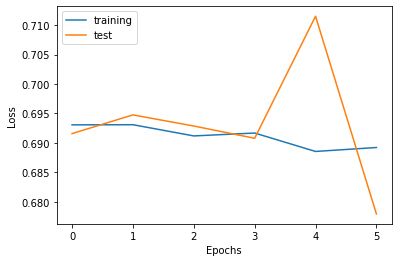

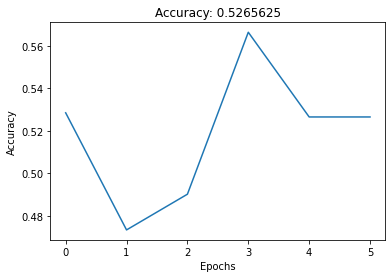

In [102]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(test_accuracies[-1]))
plt.show()
